In [3]:
# 1: Import libraries: numpy (np), pandas (pd)
# skLearn is a machine learning library
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-01-16 19:27:52.016248: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 19:27:52.080453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 19:27:52.080500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 19:27:52.082039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 19:27:52.091440: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 19:27:52.092260: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
# 2. Importing stock data using AlphaVantage API


#Install AlphaVantage and import libraries if not already imported
# !pip install alpha_vantage
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

#Free API key
key = 'UO4WWNLT3XIKJ6EI'

# Create TimeSeries object
ts = TimeSeries(key, output_format='pandas') #requires input of key and output format (default is json)

# Sample API Call for Tesla
#objects come with a data and a meta component (will likely only need data component), require a stock symbol + interval + output size
stock_data, meta = ts.get_intraday('AC', interval = '1min', outputsize='compact')
stock_data.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'}, inplace=True)

In [5]:
# 3: Preprocessing on the data
# Shift closing prices by one day to create target variable (next day's closing price): 
stock_data['Next_Close'] = stock_data['Close'].shift(-1)
    # This target variable is essentially what we are aiming to predict, if we know the next day's closing price compared to the current price, we can evaluate if the stock is worth purchasing
features = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    # We can add more features that we require if necessary
# Drop last row since it will have NaN for the shifted target
features = features[:-1]
target = stock_data['Next_Close'].dropna()

In [6]:
# 3.1: Additional data that could be used in the furture:
#Momentum = Open price – Close price
#Average price = (Low price + High price) / 2
#Range = High price – Low price
#OHLC price = (Open price + High price + Low price + Close price)/4

In [7]:
# 4: Normalize the data with min-max scaling
# Instantiate the scaler: 
scaler = MinMaxScaler(feature_range=(0, 1))
    # The feature range specifies range to scale data
# Fit and transform the data: 
scaled_data = scaler.fit_transform(features)
    # Computes the min and max of each feature and scales the data
# For each feature, min-max scaling scales the values so that the min value is represented as 0, the max as 1, and everything else in between
# Later, we may want to transform scaled values back to the original values by doing:
#original_values = scaler.inverse_transform(scaled_data)

In [8]:
# 5: Create sequences for LSTM
# Transform time series data into sequences that can be used as input into LSTM model

def create_sequences(data, target, sequence_length):
     sequences = []
     targets = []
     for i in range(len(data) - sequence_length):
         seq = data[i:i+sequence_length]
         target_value = target.iloc[i+sequence_length]
         sequences.append(seq)
         targets.append(target_value)
     return np.array(sequences), np.array(targets)

    # data are the features used to predict the target
    # target is the target variable (ex. Next day's closing price)
    # sequence_length is the number of time steps the model will look back to make a prediction
    # initialize the sequences list and targets list to store the sequences and their respective target values
    # the for loop loops over the length of the data minus the sequence length
        # ensures we have enough data to create sequences of the specified length
    # create sequences by extracting a subsequence of length sequence_length starting from index i
        #  represents the historical data that the model will use to make a prediction
    # extract the target value corresponding to the end of the sequence
    # append the sequence to the sequence list and the target value to the targets list
    # the function finally returns the sequences and targets as numpy arrays
sequence_length = 10
    # adjust length as needed
X_seq, y_seq = create_sequences(scaled_data, target, sequence_length)
    # X_seq will contain sequences of length 10 from the scaled_data features we defined earlier
    # y_seq contains the corresponding target values

# The main purpose of this step is to create sequences that we can use to train the model later

In [9]:
# 6: Split the data into training sets and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    # X_train contains the features (sequences) that will be used for training the model
    # X_test contains the features (sequences) that will be used for testing the model
    # y_train contains the corresponding target values for the training set
    # y_test contains the corresponding target values for the testing set
# We will use the test data to analyze the effectiveness of our model after it is trained

In [10]:
# 7: Build the model
model = Sequential()
    # In Keras, the sequential model is a linear stack of layers, where you can add one layer at a time
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # Adds the first LSTM layer
    # units is the number of neurons in the layer
    # return_sequences set to true ensures that the next layer in the stack receives the full sequence
    # input_shape defines shape of the first layer
model.add(LSTM(units=50))
    # Adds the second LSTM layer
    # last layer in the stack does not require return_sequences set to true as there is no next layer
model.add(Dense(units=5))
    # Adds a dense layer for output
    # One output unit (neuron)
model.compile(optimizer='adam', loss='mean_squared_error')
    # Adds a dense layer with one output unit
    # A fully connected layer to produce the model's output
    # 'adam' is a popular optimization algorithm that adapts the learning rates for each parameter
    # mean_squared_error is commonly used for regression tasks, where the goal is to minimize the difference between predicted and true values

2024-01-16 19:28:03.412069: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
#7.1: Possible GRU + LSTM model
# model = Sequential()
# model.add(GRU(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(units=256, return_sequences=True))
# model.add(Dense(units=64))
# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# This is based on this paper (https://doi.org/10.1016/j.socl.2020.100009) which used this method for FOREX daytrading
# It resulted in a more accurate results than pure LSTM as well as being more resource efficient as LSTM is typically resource hungry


In [12]:
# 8: Train the model with our data
model.fit(X_train, y_train, epochs=30, batch_size=64)
    # X_train are the input features, y_train are the target values for the training set
    # epochs is the number of times the entire training dataset is passed forward and backward through the neural network
    # the training dataset is divided into batches, and the model weights are updated after processing each batch

Epoch 1/30
2/2 [==============================] - 5s 18ms/step - loss: 1186.7728
Epoch 2/30
2/2 [==============================] - 0s 15ms/step - loss: 1183.8241
Epoch 3/30
2/2 [==============================] - 0s 16ms/step - loss: 1180.6660
Epoch 4/30
2/2 [==============================] - 0s 15ms/step - loss: 1176.9601
Epoch 5/30
2/2 [==============================] - 0s 15ms/step - loss: 1172.4595
Epoch 6/30
2/2 [==============================] - 0s 13ms/step - loss: 1166.4531
Epoch 7/30
2/2 [==============================] - 0s 14ms/step - loss: 1158.4961
Epoch 8/30
2/2 [==============================] - 0s 14ms/step - loss: 1147.4886
Epoch 9/30
2/2 [==============================] - 0s 13ms/step - loss: 1132.8751
Epoch 10/30
2/2 [==============================] - 0s 13ms/step - loss: 1113.9229
Epoch 11/30
2/2 [==============================] - 0s 14ms/step - loss: 1090.8447
Epoch 12/30
2/2 [==============================] - 0s 16ms/step - loss: 1064.8134
Epoch 13/30
2/2 [========

In [13]:
# 9: Evaluate the model with our test set
loss = model.evaluate(X_test, y_test)
    # use the test data 
    # loss is essentially the mean squared error
        # the average squared difference between the predicted values and the true values

1/1 [==============================] - 1s 1s/step - loss: 799.4778


In [14]:
# 10: Make predictions on the test set
predictions = model.predict(X_test)
    # Each element in the predictions array corresponds to the model's prediction for a specific data point in the test set
    # Basically, predictions includes the target values of each sequence
predicted_prices = scaler.inverse_transform(np.reshape(predictions, (predictions.shape[0], 5)))
    # Invereses the predictions to the original scale
actual_prices = np.reshape(y_test, (y_test.shape[0], 1))
    # Inverse transofmr the actual closing prices to original scale

# Compare predicted_prices to actual_prices to see how accurate the model is

1/1 [==============================] - 1s 1s/step


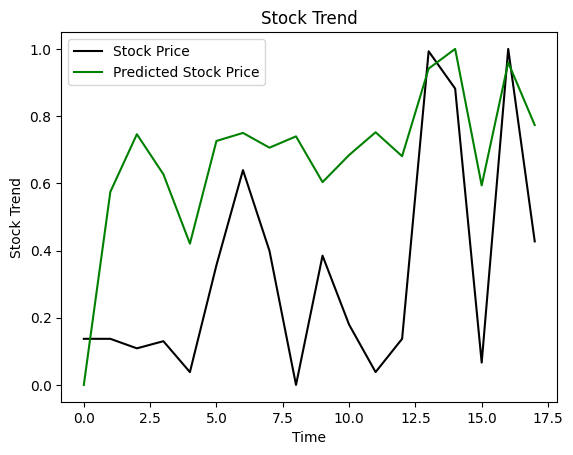

,Actual,Predicted
0,33.990,44.039932
1,33.990,44.044556
2,33.950,44.045933
3,33.980,44.044975
4,33.850,44.043312
5,34.300,44.045773
6,34.700,44.045963
7,34.360,44.045612
8,33.796,44.045883
9,34.340,44.044785


In [34]:
# 11: Dataframe for analysis
plt.plot(scaler.fit_transform(actual_prices.reshape(-1, 1)), 
         color = 'black', 
         label = 'Stock Price')
plt.plot(scaler.fit_transform(predicted_prices[:, 3].reshape(-1, 1)), 
         color = 'green', 
         label = 'Predicted Stock Price')
plt.title('Stock Trend')
plt.xlabel('Time')
plt.ylabel('Stock Trend')
plt.legend()
plt.show()


result_df = pd.DataFrame({
    'Actual': actual_prices.flatten(),
    'Predicted': predicted_prices[:, 3]
})

# Display the results
result_df.head(10)